# The Project - Advanced Lane Lines (Individual Components)

In [1]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
from scipy.misc import imresize
import cv2
import glob
%matplotlib inline
from moviepy.editor import VideoFileClip
from IPython.display import HTML

The goals / steps of this project are the following:

- Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.

This is done to correct the distortion that cameras lenses have inherently. By reading in the warped chessboard images, the goal is to find the corners (imgpoints) along with objpoints. If the corners are found, then they are drawn on the image and saved to a file. Lastly the objpoints and imgpoints obtained are passed in along with the dimensions of a sample image for example. After processing the calibration images, the output returned are the camera calibration matrix and distortion coefficients which are required for the next step.

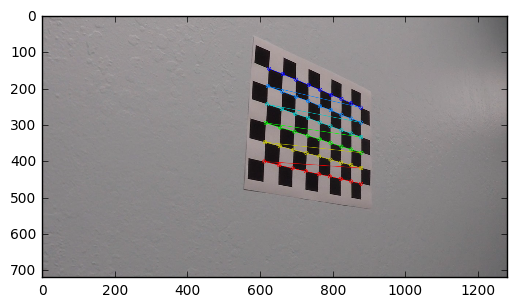

In [2]:
# prepare object points
nx = 9 # number of inside corners in x
ny = 6 # number of inside corners in y

objpoints = []
imgpoints = []
objp = np.zeros((nx*ny,3), np.float32)
objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2)

cal_images_set = glob.glob("camera_cal/calibration*.jpg")

def calibrate(image_set, objpoints, imgpoints, objp):
    
    for cal_image_name in image_set:
        cal_image = cv2.imread(cal_image_name)
        gray_image = cv2.cvtColor(cal_image, cv2.COLOR_BGR2GRAY)
    
        ret, corners = cv2.findChessboardCorners(gray_image, (nx,ny), None)
        if ret == True:
            cal_image = cv2.drawChessboardCorners(cal_image, (nx, ny), corners, ret)
            objpoints.append(objp)
            imgpoints.append(corners)
            cv2.imwrite("output_images/" + cal_image_name[11:-4] + "_with_chessboardcorners.jpg", cal_image)
            plt.imshow(cal_image)
        else: 
            cv2.imwrite("output_images/" + cal_image_name[11:-4] + "_with_no_chessboardcorners.jpg", cal_image)

    sample_image = cv2.imread('camera_cal/calibration2.jpg')
    imshape = sample_image.shape
    img_size = (sample_image.shape[1], sample_image.shape[0])            
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)
    return mtx, dist

# test images: signs_vehicles_xygrad.jpg, straight_lines1.jpg, straight_lines2.jpg,
#              test1.jpg, test2.jpg, test3.jpg, test4.jpg, test5.jpg, test6.jpg

mtx, dist = calibrate(cal_images_set, objpoints, imgpoints, objp)

- Apply a distortion correction to raw images.

Now that the camera calibration matrix and distortion coefficients are obtained, they are input to undistort the sample image.

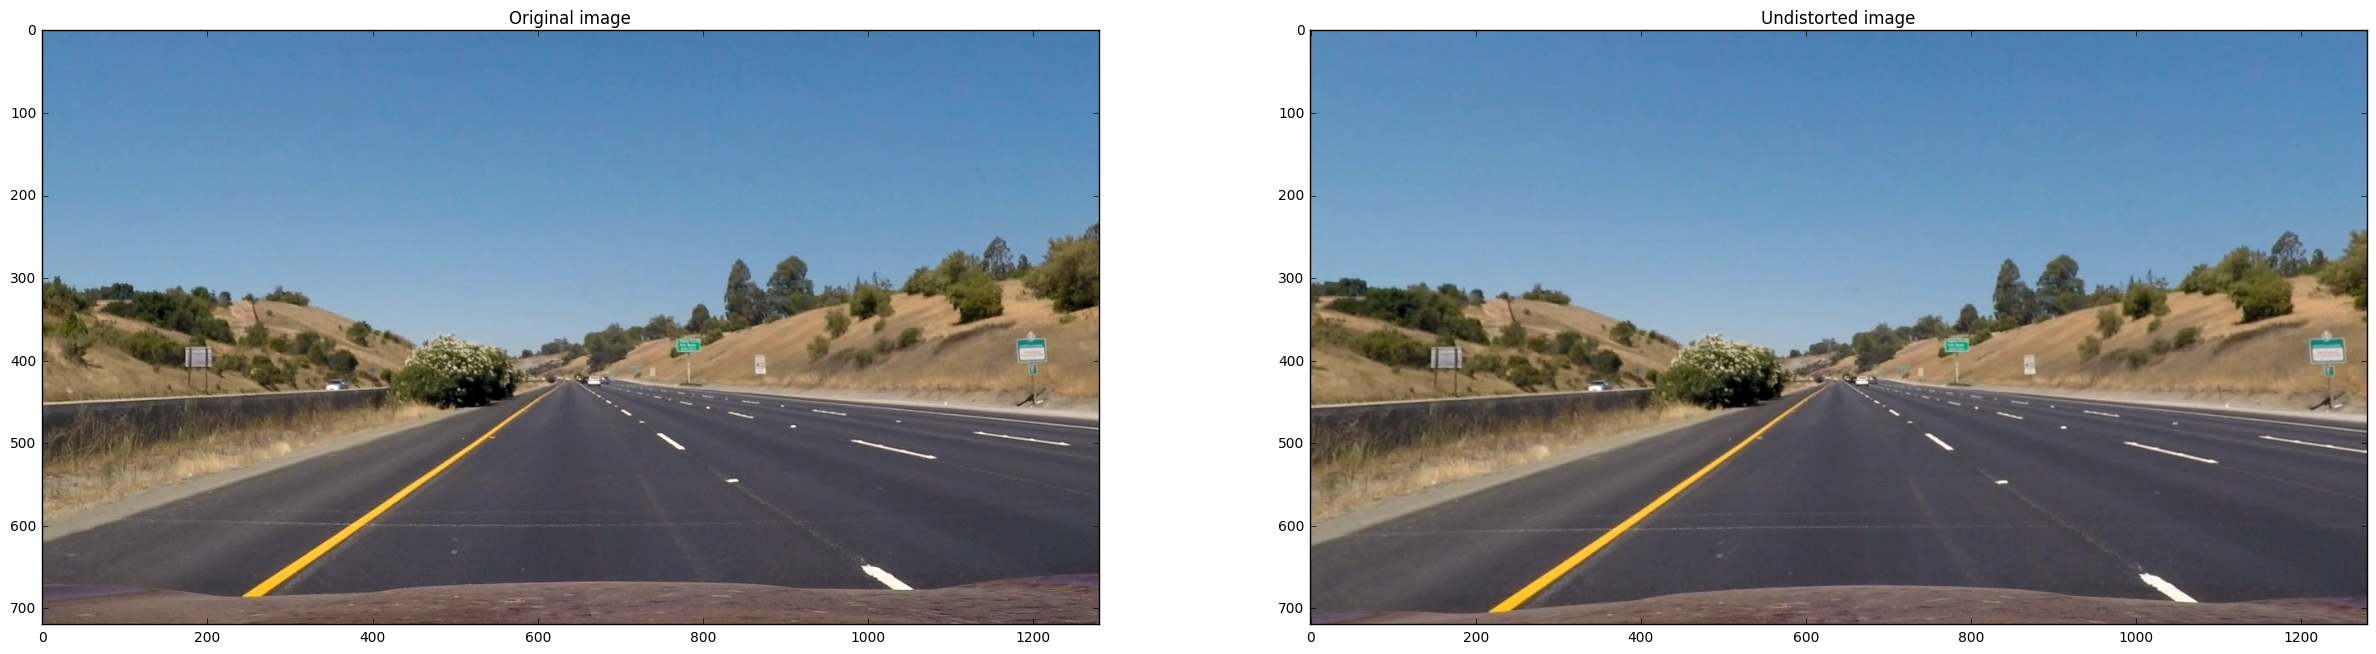

In [3]:
original_image = cv2.imread('test_images/straight_lines1.jpg')
undistorted_image = cv2.undistort(original_image, mtx, dist, None, mtx)
cv2.imwrite('test_images/straight_lines1_undistorted.jpg', undistorted_image)

f, (ax1, ax2) = plt.subplots(1,2,figsize=(30,15))
converted_original = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)
converted_undistorted = cv2.cvtColor(undistorted_image, cv2.COLOR_BGR2RGB)
ax1.imshow(converted_original)
ax1.set_title("Original image")
ax2.imshow(converted_undistorted)
ax2.set_title("Undistorted image")

- Use color transforms, gradients, etc., to create a thresholded binary image.

There are many different approaches to accomplish the end goal here. The idea is to convert to a color space and use Sobel to select pixels based on gradient strength and use a threshold to determine which pixels to set to 1 for a given color channel based on s_thresh_min and s_thresh_max. Finally given the two thresholds applied, they are then combined to output the image from the undistorted image given as input.

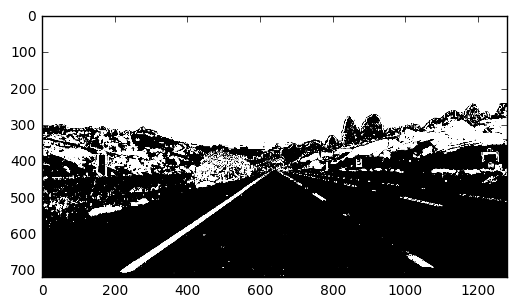

In [4]:
def apply_threshold(image):
    # Convert to HLS color space and separate the S channel
    # Note: img is the undistorted image
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]

    # Grayscale image
    # NOTE: we already saw that standard grayscaling lost color information for the lane lines
    # Explore gradients in other colors spaces / color channels to see what might work better
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

    # Sobel x
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))

    # Threshold x gradient
    thresh_min = 25
    thresh_max = 150
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

    # Threshold color channel
    s_thresh_min = 75
    s_thresh_max = 255
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh_min) & (s_channel <= s_thresh_max)] = 1

    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1

    return combined_binary

combined_image = apply_threshold(undistorted_image)

plt.imshow(combined_image, cmap='gray')

- Apply a perspective transform to rectify binary image ("birds-eye view").

To get the bird's-eye view, the perspective transform is necessary. Given the input image (using the output after applying the threshold above), the src and dst arrays get calculated based on the image shape. Returned is M, Minv and the binary_warped image.

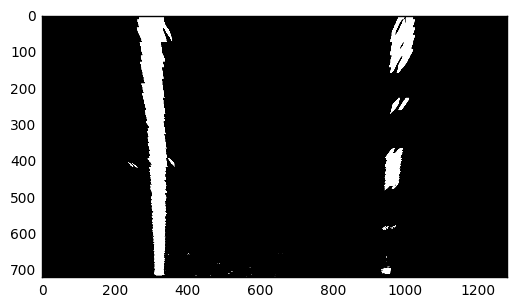

In [5]:
def get_transform_info(image_shape):
    offset = 100
    img_size = (image_shape[1], image_shape[0])

    src = np.float32(
      [[(img_size[0] / 2) - 55,     img_size[1] / 2 + offset],
      [((img_size[0] / 6) - 10),    img_size[1]],
       [(img_size[0] * 5 / 6) + 60, img_size[1]],
       [(img_size[0] / 2 + 55),     img_size[1] / 2 + offset]])
    dst = np.float32(
      [[(img_size[0] / 4),     0],
       [(img_size[0] / 4),     img_size[1]],
       [(img_size[0] * 3 / 4), img_size[1]],
       [(img_size[0] * 3 / 4), 0]])

    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    binary_warped = cv2.warpPerspective(combined_image, M, img_size, flags=cv2.INTER_LINEAR)
    return M, Minv, binary_warped

M, Minv, binary_warped = get_transform_info(combined_image.shape)
plt.imshow(binary_warped, cmap="gray")

- Detect lane pixels and fit to find the lane boundary.

The next stage is to take a histogram to identify the left and right lane line. Once that is done, splitting the lines into windows (720 / 15 ) = 48 pixels along y-axis and then define the x-axis with the margin to determine the concentration of non-zero pixels. After the left and right lane pixel positions are determined, they're passed to np.polyfit which returns a vector of coefficients p that minimises the squared error. Using those coefficients, then lines are drawn to fit a 2nd order polynomial.

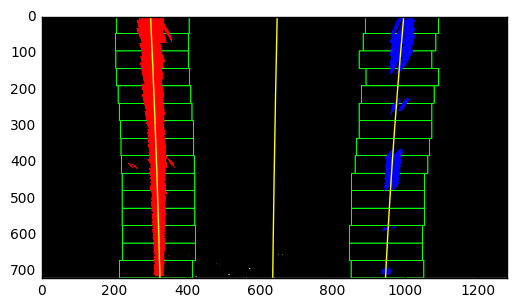

In [6]:
def process_test_frame(binary_warped):
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]/2:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 15
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2)
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    return out_img, nonzerox, nonzeroy, left_lane_inds, right_lane_inds, left_fitx, right_fitx, ploty, leftx, lefty, rightx, righty, left_fit, right_fit

out_img, nonzerox, nonzeroy, left_lane_inds, right_lane_inds, left_fitx, right_fitx, ploty, leftx, lefty, rightx, righty, left_fit, right_fit = process_test_frame(binary_warped)
out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.plot((left_fitx + right_fitx) / 2, ploty, color='yellow')

plt.xlim(0, 1280)
plt.ylim(720, 0)


def process_first_frame(binary_warped):
    out_img, nonzerox, nonzeroy, left_lane_inds, right_lane_inds, left_fitx, right_fitx, ploty, leftx, lefty, rightx, righty, left_fit, right_fit = process_test_frame(binary_warped)
    return out_img, left_fitx, right_fitx, ploty, left_fit, right_fit
 

In [ ]:
def process_next_frame(binary_warped, left_fit, right_fit):
    # Assume you now have a new warped binary image 
    # from the next frame of video (also called "binary_warped")
    # It's now much easier to find line pixels!
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    return out_img, margin, left_fit, right_fit

out_img, margin, left_fit, right_fit = process_next_frame(binary_warped, left_fit, right_fit)

- Determine the curvature of the lane and vehicle position with respect to center.

The final stage to calculate the radius of curvature is to convert the pixels to space, obtain the new coefficients and get the result from the formula below for left_curvarad and right_curverad. Lastly, roughly estimate the position of the vehicle by calculating the offset between lane center and image center (in horizontal direction).

In [7]:
def calculate_radius_of_curvature_meters(binary_warped, left_fitx, right_fitx, ploty):
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    y_eval = binary_warped.shape[0]
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    # Calculate position of vehicle
    left_lane_poly = left_fit_cr[0]*y_eval*ym_per_pix**2 + left_fit_cr[1]*y_eval*ym_per_pix + left_fit_cr[2]
    right_lane_poly = right_fit_cr[0]*y_eval*ym_per_pix**2 + right_fit_cr[1]*y_eval*ym_per_pix + right_fit_cr[2]
    lane_center = (left_lane_poly +  right_lane_poly) / 2
    vehicle_center = binary_warped.shape[1] * xm_per_pix / 2
    vehicle_position = lane_center - vehicle_center
    
    return left_curverad, right_curverad, vehicle_position

left_curverad, right_curverad, vehicle_position = calculate_radius_of_curvature_meters(binary_warped, left_fitx, right_fitx, ploty)
print(left_curverad, 'm', right_curverad, 'm', vehicle_position)

10996.4094899 m 5771.08708367 m -0.0434230076607


- Warp the detected lane boundaries back onto the original image.

Lastly, combine the lane line area with fillPoly onto the original image. 

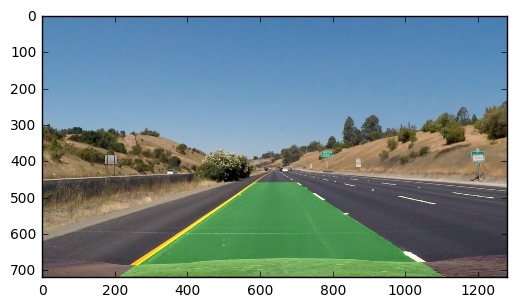

In [8]:
# Create an image to draw the lines on
warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

# Recast the x and y points into usable format for cv2.fillPoly()
pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
pts = np.hstack((pts_left, pts_right))

# Draw the lane onto the warped blank image
cv2.fillPoly(color_warp, np.int_([pts]), (0,255,0))

# Warp the blank back to original image space using inverse perspective matrix (Minv)
newwarp = cv2.warpPerspective(color_warp, Minv, (original_image.shape[1], original_image.shape[0])) 
# Combine the result with the original image
result = cv2.addWeighted(original_image, 1, newwarp, 0.3, 0)
converted_result = cv2.cvtColor(result, cv2.COLOR_BGR2RGB)
plt.imshow(converted_result)

- Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

Finally, put up the stats from earlier that calculated the curvature and vehicle position.

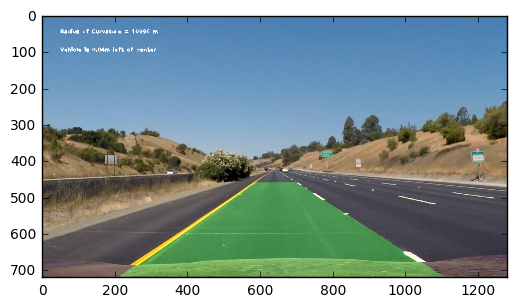

In [9]:
font = cv2.FONT_HERSHEY_PLAIN
cv2.putText(result, 'Radius of Curvature = %d m' % left_curverad, (50, 50), font, 1, (255, 255, 255), 2)
position_of_vehicle = "left" if vehicle_position < 0 else "right"
cv2.putText(result, 'Vehicle is %.2fm %s of center' % (np.abs(vehicle_position), position_of_vehicle), (50, 100), font, 1,
            (255, 255, 255), 2)
converted_result = cv2.cvtColor(result, cv2.COLOR_BGR2RGB)
plt.imshow(converted_result)